In [19]:
from torch.utils.data import DataLoader
import torch
from torch.optim import AdamW as TorchAdamW
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
import matplotlib.pyplot as plt

In [4]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dataset = load_dataset("imdb", split="train[:2000]").train_test_split(test_size=0.2)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 400/400 [00:00<00:00, 489.32 examples/s]


In [10]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True)
test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)

Эпоха 1/3, Средняя потеря: 0.0100
Эпоха 2/3, Средняя потеря: 0.0001
Эпоха 3/3, Средняя потеря: 0.0000


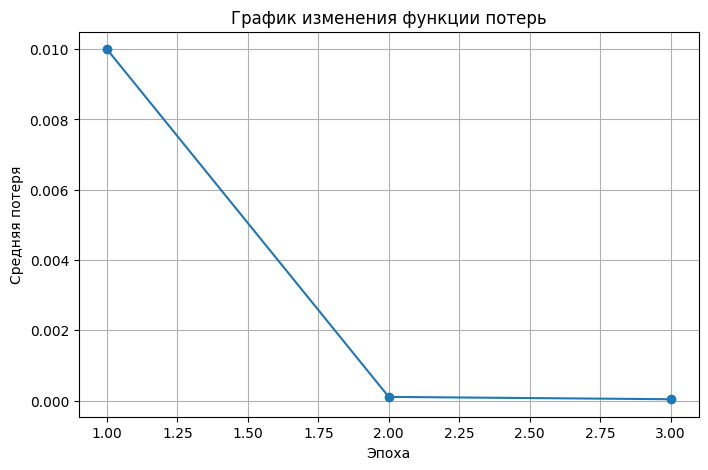

In [14]:
device = torch.device("mps")
model.to(device)

optimizer = TorchAdamW(model.parameters(), lr=5e-5)  # AdamW из PyTorch

num_epochs = 3
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Эпоха {epoch+1}/{num_epochs}, Средняя потеря: {avg_loss:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o", linestyle="-")
plt.title("График изменения функции потерь")
plt.xlabel("Эпоха")
plt.ylabel("Средняя потеря")
plt.grid(True)
plt.show()

In [22]:
text = "This movie was absolutely good!"

inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
inputs = {key: value.to(device) for key, value in inputs.items()}

model.eval()

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits


predicted_class = torch.argmax(logits, dim=-1).item()
probabilities = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()

print(f"🔹 Входной текст: {text}")
print(f"🔹 Предсказанный класс: {predicted_class} ({'Positive' if predicted_class == 1 else 'Negative'})")

🔹 Входной текст: This movie was absolutely good!
🔹 Предсказанный класс: 0 (Negative)
